In [1]:
# Download nltk corpora required
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package punkt to /home/sherlock/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/sherlock/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /home/sherlock/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /home/sherlock/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [2]:
# Import required packages
import os
import uuid
import json
import numpy as np
import pandas as pd
from goose3 import Goose
from nltk import ne_chunk, pos_tag, word_tokenize
from nltk.tree import Tree
from newsapi import NewsApiClient
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from multiprocessing import Process, Queue
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Constants for fetching news articles
news_sources = [
    'bbc-news',
    'vice-news',
    'the-guardian-uk',
    'independent',
    'the-economist',
    'the-telegraph',
    'the-new-york-times',
    'the-wall-street-journal',
    'reuters',
    'associated-press',
]
from_date = '2018-08-10T00:00:00'
to_date = '2018-08-10T00:00:00'
API_KEY = 'dbace9892af44bd8a61098abddb53d13'

In [4]:
# Fetch all articles in date range for news sources
# Does not handle refetching the same article

PAGE_SIZE = 100
page = 1
raw_articles = []
newsapi = NewsApiClient(api_key=API_KEY)
while True:
    response =  newsapi.get_everything(
        sources=','.join(news_sources),
        from_param=from_date,
        to=to_date,
        language='en',
        sort_by='publishedAt',
        page=page,
        page_size=PAGE_SIZE,
    )
    if response['status'] != 'ok':
        raise Exception('Error querying news api', response)
    raw_articles += response['articles']
    if PAGE_SIZE * page >= response['totalResults']:
        break;
    page += 1
print(page)
print(len(raw_articles))    

25
2470


In [5]:
# A class to encapsulate an article
# It uses the url to fetch the article content and extract named entities from it

goose = Goose()

class Article:
    def __init__(self, url, title, description):
        self.id = uuid.uuid4()
        self.url = url
        self.title = title
        self.description = description
        raw_content = goose.extract(url=url).cleaned_text
        self.named_entities = self.extract_named_entities(raw_content)
        
    def extract_named_entities(self, text):
        chunked = ne_chunk(pos_tag(word_tokenize(text)))
        prev = None
        continuous_chunk = []
        current_chunk = []
        for i in chunked:
            if type(i) == Tree:
                current_chunk.append(" ".join([token for token, pos in i.leaves()]))
            elif current_chunk:
                named_entity = " ".join(current_chunk)
                if named_entity not in continuous_chunk:
                    continuous_chunk.append(named_entity)
                    current_chunk = []
                else:
                    continue
        return continuous_chunk

In [6]:
# Map over the raw articles from the news api and construct Article objects
def single_core_article_builder():
    articles = []

    for a in raw_articles:
        try:
            articles.append(Article(a['url'], a['title'], a['description']))
        except:
            continue
    return articles

In [7]:
# Multicore article building
def multi_core_article_builder():
    CORES = int(os.environ['NUM_CPUS'])

    def doWork(q, a):
        results = []
        for article in a:
            try:
                results.append(Article(
                    article['url'],
                    article['title'],
                    article['description']
                ))
            except:
                continue
        q.put(results)

    q = Queue()
    subprocesses = []
    for i in range(CORES):
        start = int(i * (len(raw_articles)/CORES))
        end = int((i + 1) * (len(raw_articles)/CORES))
        p = Process(target=doWork, args=(q, raw_articles[start:end]))
        p.start()
        subprocesses.append(p)

    articles = []
    for i in range(CORES):
        articles.extend(q.get(True))
    while subprocesses:
        subprocesses.pop().join()
    return articles

In [8]:
CORES = int(os.environ['NUM_CPUS'])

if CORES > 1:
    print(f'Running on {CORES} cores')
    %time articles = multi_core_article_builder()
else:
    print('Running on single core')
    %time articles = single_core_article_builder()
print('Finished')

Running on 4 cores
CPU times: user 48 ms, sys: 48 ms, total: 96 ms
Wall time: 8min 23s
Finished


In [9]:
# Create tf_idf matrix from articles
named_entities_list = list(map(lambda x: ' '.join(x.named_entities), articles))
tfidf_vectorizer = TfidfVectorizer()
%time tfidf_matrix = tfidf_vectorizer.fit_transform(named_entities_list)
print(tfidf_matrix.shape)

CPU times: user 136 ms, sys: 4 ms, total: 140 ms
Wall time: 167 ms
(2451, 14277)


In [10]:
# Run k-means clustering on tf_idf matrix
num_clusters = 7
km = KMeans(n_clusters=num_clusters)
%time km.fit(tfidf_matrix)
clusters = km.labels_.tolist()

CPU times: user 10.2 s, sys: 572 ms, total: 10.8 s
Wall time: 2.73 s


In [11]:
def print_cluster_terms():
    print("Top terms per cluster:")
    order_centroids = km.cluster_centers_.argsort()[:, ::-1]
    terms = tfidf_vectorizer.get_feature_names()
    for i in range(num_clusters):
        print("Cluster %d:" % i),
        cluster_terms = []
        for ind in order_centroids[i, :10]:
             cluster_terms.append(terms[ind])
        print(' '.join(cluster_terms))
        print
print_cluster_terms()

Top terms per cluster:
Cluster 0:
britain uk fraser london british ryanair france brexit house eu
Cluster 1:
turkey turkish erdogan trump ankara tayyip states european united washington
Cluster 2:
mourinho manchester city guardiola liverpool united emery arsenal chelsea sarri
Cluster 3:
new canada york fredericton mexico canadian pga saudi woodland reuters
Cluster 4:
ap reuters county india england new united university north south
Cluster 5:
trump russia house russian donald white washington united states us
Cluster 6:
china chinese beijing iran united states reuters xinjiang lvmh european


In [12]:
test_url = 'https://www.thesun.co.uk/money/6983750/house-of-fraser-administration-mike-ashley-sports-direct-cash/'
test_article = Article(test_url, '', '')
print(test_article.named_entities)
Y = tfidf_vectorizer.transform([' '.join(test_article.named_entities)])
prediction = km.predict(Y)
print(prediction)

['HOUSE Of Fraser', 'Mike Ashley', 'Sports Direct', 'Ashley', 'Sports Direct Newcastle United', 'Ashley House', 'Fraser', 'Ashley Pension Protection Fund', 'Sports Direct Mike Ashley', 'Edinburgh Wollen Mill', 'Philip', 'Alteri', 'Endless', 'Mike Ashley House', 'Fraser Harrods', 'High', 'House', 'Fraser Company', 'CVA', 'Alex Williamson', 'House Fraser', 'Frank Slevin', 'House Fraser Cenbest', 'House Fraser Glasgow', 'Hugh Fraser', 'James Arthur', 'Second', 'Unions', 'Sport Direct', 'East Midlands', 'MPs', 'Victorian', 'Scott Lennon', 'Unite', 'Sports Direct House', 'Fraser House', 'Fraser BHS', 'Toys R Us', 'UK', 'Poundworld', 'Sun Online Money', 'Sun Money', 'Facebook']
[0]


In [13]:
clusters = km.predict(tfidf_matrix)

In [14]:
cluster_article_map = {}
cluster_article_title_map = {}
for i in range(len(articles)):
    cluster = clusters[i]
    article = articles[i]
    if cluster in cluster_article_map.keys():
        cluster_article_map[cluster].append(article)
    else:
        cluster_article_map[cluster] = [article]
    if cluster in cluster_article_title_map.keys():
        cluster_article_title_map[cluster].append(article.title)
    else:
        cluster_article_title_map[cluster] = [article.title]

In [15]:
cluster_article_title_map[2]

['Man Utd v Leicester - Pogba captain, Lukaku & Vardy subs - BBC Sport',
 'Arsenal news: Unai Emery quietly confident that he can finally end long losing streak to Pep Guardiola',
 'Manchester United vs Leicester City, Premier League 2018-19: live score and latest updates',
 'Maurizio Sarri warns against quick fix at Chelsea ahead of season opener',
 'Unai Emery starts from a fresh slate at Arsenal - and herein lays his greatest challenge',
 'Jamie Vardy ends transfer speculation and commits long-term future to Leicester City',
 'Manchester City manager Pep Guardiola hits out at Argentina FA president for salary comments',
 'Arsenal vs Manchester City, Premier League 18-19: What time is kick-off on Sunday, what TV channel is it on and what is our prediction?',
 'How will Manchester United line-up this season? How Fred, Paul Pogba and Anthony Martial fit into the same side',
 'Danny Welbeck: Arsenal boss Unai Emery does not plan to sell forward this summer',
 'Midfielder Douglas Luiz re

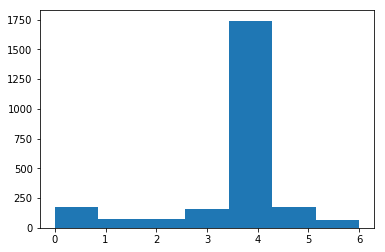

In [16]:
plt.hist(km.labels_, bins=num_clusters)
plt.show()

In [17]:

import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS
from sklearn.metrics.pairwise import cosine_similarity

dist = 1 - cosine_similarity(tfidf_matrix)

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]
print()
print()

titles = list(map(lambda x: x.title, articles))
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

In [18]:
#set up colors per clusters using a dict
cluster_colors = {
    0: '#FFE981',
    1: '#FF6748',
    2: '#BBDED6',
    3: '#BEEB9F',
    4: '#F8B595',
    5: '#F67280',
    6: '#C06C84',
    7: '#6C5B7C',
    8: '#FFB6B9',
    9: '#FF9797',
}

#set up cluster names using a dict
cluster_names = {
    0: 'A', 
    1: 'B', 
    2: 'C', 
    3: 'D', 
    4: 'E',
    5: 'F',
    6: 'G',
    7: 'H',
    8: 'I',
    9: 'J',
}

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


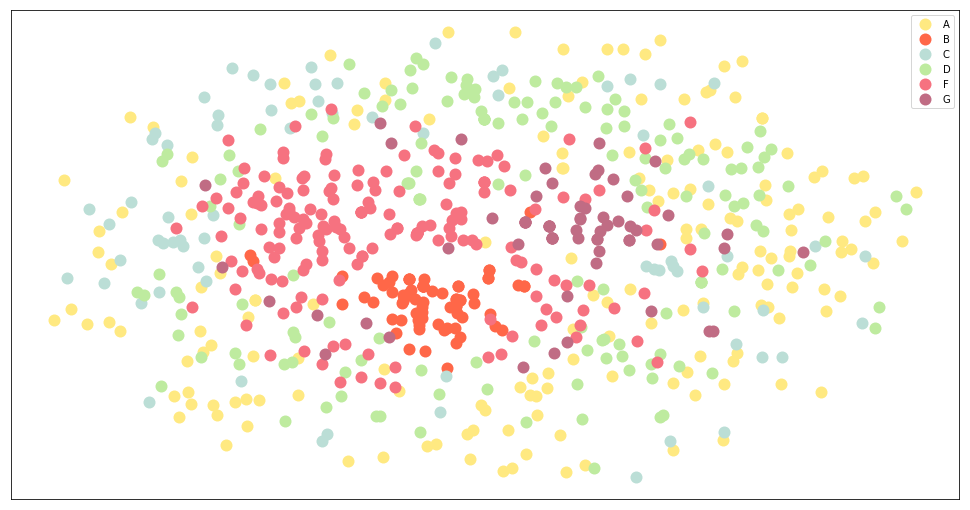

In [19]:
%matplotlib inline 
#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    if name == 4:
        continue
    ax.plot(
        group.x,
        group.y,
        marker='o',
        linestyle='',
        ms=12, 
        label=cluster_names[name],
        color=cluster_colors[name], 
        mec='none'
    )
    ax.set_aspect('auto')
    ax.tick_params(
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
#for i in range(len(df)):
#    ax.text(df.iloc[i]['x'], df.iloc[i]['y'], df.iloc[i]['title'], size=8)  

    
    
plt.show() #show the plot

In [20]:
print_cluster_terms()

Top terms per cluster:
Cluster 0:
britain uk fraser london british ryanair france brexit house eu
Cluster 1:
turkey turkish erdogan trump ankara tayyip states european united washington
Cluster 2:
mourinho manchester city guardiola liverpool united emery arsenal chelsea sarri
Cluster 3:
new canada york fredericton mexico canadian pga saudi woodland reuters
Cluster 4:
ap reuters county india england new united university north south
Cluster 5:
trump russia house russian donald white washington united states us
Cluster 6:
china chinese beijing iran united states reuters xinjiang lvmh european


In [40]:
from sklearn.neighbors import NearestNeighbors

# Create tf_idf matrix from articles
test_named_entities_list = list(map(lambda x: ' '.join(x.named_entities), articles))
print(len(test_named_entities_list))
test_named_entities_list.append(' '.join(test_article.named_entities))
print(len(test_named_entities_list))
test_tfidf_vectorizer = TfidfVectorizer()
test_tfidf_matrix = test_tfidf_vectorizer.fit_transform(test_named_entities_list)
print(test_tfidf_matrix.shape)
nbrs = NearestNeighbors(n_neighbors=9) 
nbrs.fit(test_tfidf_matrix)

distances, indices = nbrs.kneighbors(test_tfidf_matrix.getrow(len(test_named_entities_list) - 1))
print(distances, indices)
similar_articles = []
for idx in indices.flatten()[1:]:
    similar_articles.append(articles[idx])

result = pd.DataFrame({
    'distance': distances.flatten()[1:],
    'titles': list(map(lambda x: x.title, similar_articles)),
})
print(result)

2451
2452
(2452, 14281)
[[0.         0.61613043 0.62682906 0.65867035 0.68475849 0.73014314
  0.73014314 0.73014314 0.73014314]] [[2451 1381 1414 2106 2318 2190 1384 1383 2286]]
   distance                                             titles
0  0.616130  House of Fraser calls in administrators as res...
1  0.626829            House of Fraser calls in administrators
2  0.658670  House of Fraser takeover: Unions warn of job f...
3  0.684758  Sports Direct owner Mike Ashley confirms purch...
4  0.730143  UPDATE 3-Sports Direct snaps up House of Frase...
5  0.730143  UPDATE 1-UK retailer House of Fraser set to ap...
6  0.730143  House of Fraser set to appoint administrators ...
7  0.730143  Sports Direct buys House of Fraser from admini...
